## Import

In [1]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import math

import matplotlib.pyplot as plt

## Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Init some dir

In [3]:
destination_dir = '/content/drive/MyDrive/fruit_dataset'
train_dir = os.path.join(destination_dir, 'train')
validation_dir = os.path.join(destination_dir, 'validation')
test_dir = os.path.join(destination_dir, 'test')

## Data augmented for train dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.5, 1.0],
    rotation_range=90, # random in range [-90, 90]
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

validation_datagen = ImageDataGenerator(rescale=1./255)


## Image Data Generator

In [5]:
epochs = 30
batch_size = 32

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    color_mode="rgb",
                                                    target_size=(224,224),
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=batch_size,
                                                         color_mode="rgb",
                                                         target_size=(224,224),
                                                         class_mode='binary')

Found 1048 images belonging to 2 classes.
Found 351 images belonging to 2 classes.


# Transfer Learning

In [7]:
pre_trained_model = VGG19(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [8]:
train_len = 0
for foldername in os.listdir(os.path.join(destination_dir, 'train')):
    train_len = train_len + len(os.listdir(os.path.join(destination_dir,'train',foldername)))

val_len = 0
for foldername in os.listdir(os.path.join(destination_dir, 'validation')):
    val_len = val_len + len(os.listdir(os.path.join(destination_dir, 'validation',foldername)))

print(train_len)
print(val_len)

1048
351


## Custom Callbacks function

In [9]:
checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/dfr/checkpoints',
    "{epoch:03d}-{val_loss:.4f}.h5",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4,
    restore_best_weights=True
)

# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
callbacks = [checkpoint, early_stopping]

## Train

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len//batch_size),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=(val_len//batch_size)
)

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 2.3728 - accuracy: 0.6781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 278s 8s/step - loss: 2.3728 - accuracy: 0.6781 - val_loss: 1.2444 - val_accuracy: 0.7375
Epoch 2/30
32/32 [==============================] - 21s 643ms/step - loss: 0.8995 - accuracy: 0.8514 - val_loss: 0.7054 - val_accuracy: 0.8562
Epoch 3/30
32/32 [==============================] - 20s 630ms/step - loss: 0.6552 - accuracy: 0.8455 - val_loss: 0.6093 - val_accuracy: 0.8062
Epoch 4/30
32/32 [==============================] - 21s 650ms/step - loss: 0.5458 - accuracy: 0.8573 - val_loss: 0.4620 - val_accuracy: 0.9031
Epoch 5/30
32/32 [==============================] - 19s 607ms/step - loss: 0.5134 - accuracy: 0.8484 - val_loss: 0.4960 - val_accuracy: 0.8156
Epoch 6/30
32/32 [==============================] - 21s 665ms/step - loss: 0.4833 - accuracy: 0.8506 - val_loss: 0.3970 - val_accuracy: 0.8781
Epoch 7/30
32/32 [==============================] - 20s 621ms/step - loss: 0.4250 - accuracy: 0.8770 - val_loss: 0.3810 - val_accuracy: 0.9281
Epoch 8/30
3

## Plot training and validation accuracy

<Figure size 640x480 with 0 Axes>

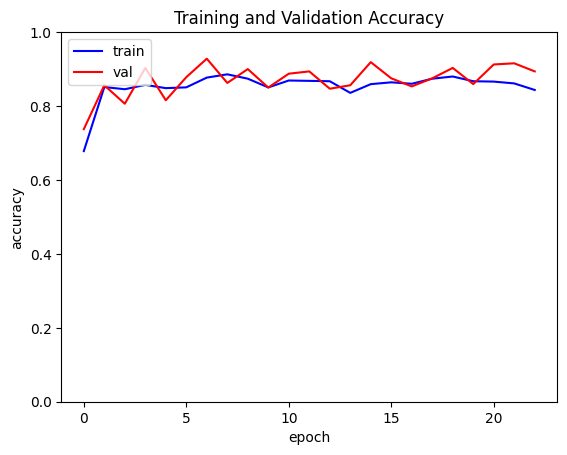

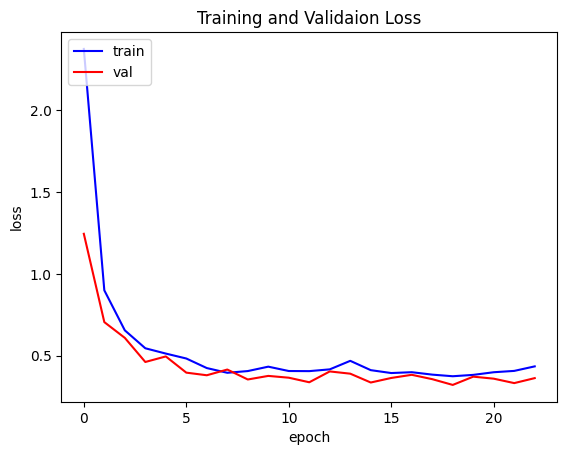

<Figure size 640x480 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

## Caculate accuracy of test dataset

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(224, 224),
                                                  shuffle = False,
                                                  class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss test: ',loss)

Found 349 images belonging to 2 classes.
349/349 [==============================] - 98s 278ms/step - loss: 0.2886 - accuracy: 0.9140
accuracy test:  0.9140400886535645
loss test:  0.2886430025100708


## Save the model

In [15]:
model.save('vgg19_final_0402.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### This cell is being run on Google Colab. Please ignore this cell if you are not using Google Colab

In [ ]:
from keras.utils import get_file
import pathlib
import cv2
from google.colab import files
from keras.preprocessing import image
import numpy as np

model_predict = tf.keras.models.load_model('vgg19_final_0402.h5')
model_predict.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

uploaded = files.upload()
image_name = []
image_conf = []
predict_result = []

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224, 224), interpolation="nearest")
  # imgplot = plt.imshow(img)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])
  classes = model_predict.predict(images, batch_size=10)
  label = np.where(classes[0] > 0.5, 1,0)
  # print(label)
  if label == 0:
    image_name.append(fn)
    image_conf.append(1.0 - classes[0])
    predict_result.append('Fresh Orange')
  else:
    image_name.append(fn)
    image_conf.append(classes[0])
    predict_result.append('Rotten Orange')

plt.figure(figsize=(15, 15))
for n in range(len(image_name)):
  plt.subplot((math.ceil(len(image_name)/4))+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(image_name[n], color_mode="rgb", target_size=(224, 224), interpolation="nearest"))
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
  if predict_result[n] == 'Fresh Fruit':
    plt.title(title, color='black')
  else:
    plt.title(title, color='red')

  plt.axis('off')
plt.show()

for fn in image_name:
  os.system(f'rm {fn}')

# Evalute Model

In [13]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_generator)
predicted_classes = (test_predictions > 0.5).astype(int)

true_labels = test_generator.classes

print("Test Set Classification Report:")
print(classification_report(true_labels, predicted_classes))


349/349 [==============================] - 4s 12ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       100
           1       0.93      0.96      0.94       249

    accuracy                           0.91       349
   macro avg       0.90      0.88      0.89       349
weighted avg       0.91      0.91      0.91       349

